In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gc
import os


## READING AND EXPLORING DATA

In [2]:
train= pd.read_csv('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')

In [3]:
train.isnull().sum()

image       0
cultivar    1
dtype: int64

In [4]:
train_dir='../input/sorghum-id-fgvc-9/train_images/'

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

sample_image  = load_img(f"{os.path.join(train_dir, os.listdir(train_dir)[0])}")
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (1024, 1024, 3)
The maximum pixel value used is: 255.0


In [6]:
train=train.dropna(axis=0)

<AxesSubplot:>

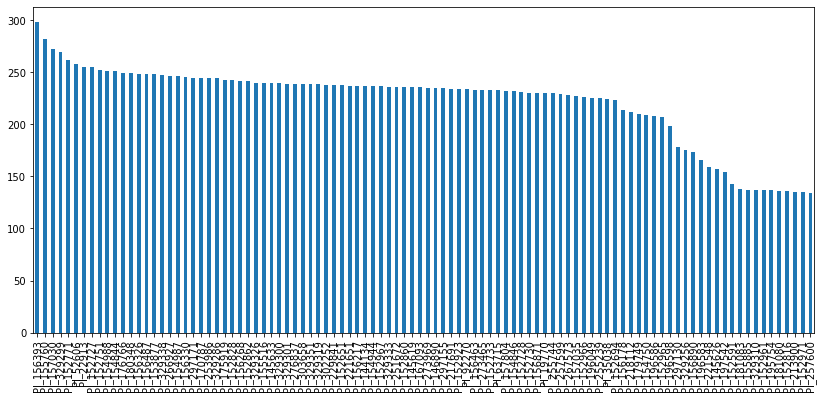

In [7]:
# iMAGES UNDER EACH LABEL
train['cultivar'].value_counts().plot(kind='bar', figsize=(14,6))

In [8]:
train['cultivar']=train['cultivar'].astype(str)

In [9]:
labels=list(np.unique(train['cultivar']))

## CREATING TRAIN AND VALIDATION SETS

#### AUGMENTATION

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rotation_range=.20,      
            shear_range=0.7,  
                                   
            horizontal_flip=True,         
            validation_split=0.2
)


In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    color_mode='rgb',
    class_mode='categorical',
    classes=labels,

    
    target_size=(256, 256),
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 17755 validated image filenames belonging to 100 classes.


In [12]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='image',
    y_col='cultivar',
    color_mode='rgb',
   
    class_mode='categorical',
    classes=labels,
    target_size=(256, 256),
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 4438 validated image filenames belonging to 100 classes.


In [13]:
gc.collect()

174

## PRE-TRAINED MODEL EFFICIENTNET B2

In [14]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers


pre_trained_model =Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))
#pre_trained_model.trainable = False


2022-05-28 02:07:34.846580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 02:07:34.949669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 02:07:34.950413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 02:07:34.951533: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [15]:
#stateless_random_crop = tf.image.stateless_random_crop(image, size=[210, 300, 3], seed=seed)
preprocess_input =tf.keras.applications.xception.preprocess_input

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(.2),
  layers.RandomTranslation(height_factor=.1, width_factor=.30),
])

In [17]:
import tensorflow_addons as tfa
     
batch_size = 32
epochs = 10
init_lr = 1e-4
max_lr = 1e-2
        
steps_per_epoch = len(train_generator)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=init_lr,
        maximal_learning_rate=max_lr,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)

In [18]:
from tensorflow.keras import Model


inputs = keras.Input(shape=(256, 256, 3))

x=preprocess_input(inputs)
x=data_augmentation(x)
x = pre_trained_model(x)
x =  layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x= layers.Dense  (100, activation='softmax')(x)           

model = Model(inputs, x) 


optimizer=tf.keras.optimizers.Adam(learning_rate=clr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
check_point_best= keras.callbacks.ModelCheckpoint('keras_model.h5',save_best_only = True)

In [20]:
gc.collect()

7760

In [21]:
history=model.fit(train_generator,  validation_data=valid_generator, epochs=7, callbacks=check_point_best)

2022-05-28 02:07:42.323925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-05-28 02:07:49.617097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


555/555 [==============================] - 1315s 2s/step - loss: 3.2659 - accuracy: 0.1974 - val_loss: 22.7019 - val_accuracy: 0.0388


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
555/555 [==============================] - 1331s 2s/step - loss: 2.4998 - accuracy: 0.3288 - val_loss: 39.6701 - val_accuracy: 0.0288
Epoch 3/7
555/555 [==============================] - 1329s 2s/step - loss: 1.7777 - accuracy: 0.4919 - val_loss: 7.2560 - val_accuracy: 0.2059
Epoch 4/7
555/555 [==============================] - 1366s 2s/step - loss: 0.9032 - accuracy: 0.7156 - val_loss: 0.4938 - val_accuracy: 0.8405
Epoch 5/7
555/555 [==============================] - 1387s 2s/step - loss: 0.6097 - accuracy: 0.8068 - val_loss: 2.4068 - val_accuracy: 0.4540
Epoch 6/7
555/555 [==============================] - 1305s 2s/step - loss: 0.9185 - accuracy: 0.7141 - val_loss: 5.8074 - val_accuracy: 0.2053
Epoch 7/7
555/555 [==============================] - 1348s 2s/step - loss: 0.7977 - accuracy: 0.7500 - val_loss: 1.6285 - val_accuracy: 0.5726


## PLOTTING  ACCURACY

Text(0.5, 1.0, 'Training and Validation Accuracy')

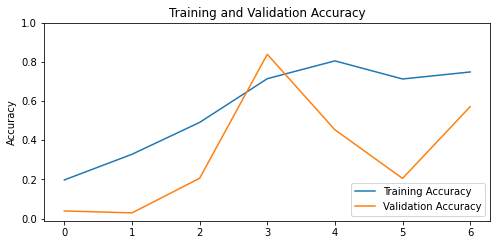

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



### TEST PREDICTIONS